In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

# from seaborn import despine
import matplotlib.pyplot as plt
plt.rc("axes.spines", top=False, right=False)

from analysis_functions import compute_gaze_influence, sci_notation, run_linear_model, compute_mean_rt, compute_p_choose_best, write_summary, make_sure_path_exists

/Users/felixmolter/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
make_sure_path_exists('results/linear_models')

In [3]:
np.random.seed(52) # from random.org

# 3.2. Absolute model fit (out of sample prediction)

In [4]:
print('Assessing absolute model fit...')

Assessing absolute model fit...


### Load plot function

In [5]:
def plot_correlation(x, y,
                     model_names=None,
                     xlabel='',
                     ylabel='',
                     title='',
                     ci=0.95,
                     xticks=None,
                     yticks=None,
                     xticklabels=None,
                     yticklabels=None,
                     xlim=None,
                     ylim=None,
                     annotation_pos=(0.1, 0.1),
                     annotation_halign='left',
                     fontsize_title=15,
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_annotation=12,
                     plot_diagonal=False,
                     ax=None):

    # Defaults
    if ax is None:
        fig, ax = plt.subplots()
    if not isinstance(y, list):
        y = [y]
    if model_names is None:
        model_names = ['Model {}'.format(i)
                       for i in range(len(y))]
    
    for i, yi in enumerate(y):
        # Scatter
        ax.scatter(x, yi, color='C{}'.format(i), alpha=0.5)

        # LM fit
        X = sm.add_constant(x)
        lm = sm.OLS(yi, X).fit()
        intercept, slope = lm.params
        table, data, columns = summary_table(lm, alpha=1.-ci)
        predicted, mean_ci_lower, mean_ci_upper = data[:, np.array([2, 4, 5])].T

         # Annotation
        tval = lm.tvalues[-1]
        pval = lm.pvalues[-1]
        if pval < 0.01:
            pstring = ' < ' + sci_notation(pval, decimal_digits=2)
        else:
            pstring = ' = {:.2f}'.format(pval)
        r = np.sign(tval) * np.sqrt(lm.rsquared)
        label = ((r'$r = {:.2f}$, '.format(r)) +
                  r'$P${}'.format(pstring))
        xs = np.linspace(*ax.get_xlim(), 100)
        ax.plot(xs, intercept + slope * xs,
                color='C{}'.format(i), label=label)
        sort_idx = np.argsort(x)
        ax.fill_between(x[sort_idx], mean_ci_lower[sort_idx], mean_ci_upper[sort_idx],
                        color='C{}'.format(i), alpha=0.1)

    ax.legend(loc='best', fontsize=fontsize_annotation, frameon=False)

    # Axes, ticks, ...
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
        
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, fontsize=fontsize_ticklabels)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels, fontsize=fontsize_ticklabels)

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Diagonal
    if plot_diagonal:
        ax.plot([0, 1], [0, 1], transform=ax.transAxes,
                color='black', alpha=.5, zorder=-10, lw=2)

    # Labels
    ax.set_xlabel(xlabel, fontsize=fontsize_axeslabel)
    ax.set_ylabel(ylabel, fontsize=fontsize_axeslabel)
    ax.set_title(title, fontsize=fontsize_title)
#     despine()

    return ax

## Load *observed* data (test set) GLAM out of sample *predictions*

In [6]:
test_data = pd.read_csv('data/krajbich_2011_pnas/data_pnas2011_preprocessed_test.csv')

glam_full = pd.read_csv('results/predictions/glam_full_hierarchical_cv.csv')
glam_nobias = pd.read_csv('results/predictions/glam_nobias_hierarchical_cv.csv')

# Compute behavioral indices for observed data and predictions

In [7]:
mean_rt = pd.DataFrame(dict(observed=compute_mean_rt(test_data),
                            glam_full=compute_mean_rt(glam_full),
                            glam_nobias=compute_mean_rt(glam_nobias)))

p_choose_best = pd.DataFrame(dict(observed=compute_p_choose_best(test_data),
                            glam_full=compute_p_choose_best(glam_full),
                            glam_nobias=compute_p_choose_best(glam_nobias)))

gaze_influence = pd.DataFrame(dict(observed=compute_gaze_influence(test_data),
                                   glam_full=compute_gaze_influence(glam_full),
                                   glam_nobias=compute_gaze_influence(glam_nobias)))

## Linear models: Are out of sample data predicted by GLAM variants?

### 1. Full GLAM

#### 1.1 Mean RT

In [8]:
print('  1. Full GLAM...')
print('  1.1 Mean RT')
_ = run_linear_model(mean_rt['glam_full'],
                     mean_rt['observed'])
write_summary(_, 'results/linear_models/3_absfit_fullglam_rt.csv')

  1. Full GLAM...
  1.1 Mean RT
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     684.7
Date:                Mon, 04 Dec 2017   Prob (F-statistic):           3.18e-21
Time:                        07:25:48   Log-Likelihood:                -208.26
No. Observations:                  30   AIC:                             420.5
Df Residuals:                      28   BIC:                             423.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -67.018

#### 1.2 P(choose best)

In [9]:
print('  1.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_full'],
                     p_choose_best['observed'])
write_summary(_, 'results/linear_models/3_absfit_fullglam_pchoosebest.csv')

  1.2 P(choose best)
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     73.37
Date:                Mon, 04 Dec 2017   Prob (F-statistic):           2.61e-09
Time:                        07:25:48   Log-Likelihood:                 45.636
No. Observations:                  30   AIC:                            -87.27
Df Residuals:                      28   BIC:                            -84.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2030      0.06

#### 1.3 Gaze influence on P(choose left)

In [10]:
print('  1.3 Gaze Influence')
_ = run_linear_model(gaze_influence['glam_full'],
                     gaze_influence['observed'])
write_summary(_, 'results/linear_models/3_absfit_fullglam_gazeinfluence.csv')

  1.3 Gaze Influence
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     44.81
Date:                Mon, 04 Dec 2017   Prob (F-statistic):           2.89e-07
Time:                        07:25:48   Log-Likelihood:                 26.454
No. Observations:                  30   AIC:                            -48.91
Df Residuals:                      28   BIC:                            -46.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0432      0.03

### 2. No-Bias GLAM

#### 2.1 Mean RT

In [11]:
print('  2. No-Bias GLAM')
print('  2.1 Mean RT')
_ = run_linear_model(mean_rt['glam_nobias'],
                     mean_rt['observed'])
write_summary(_, 'results/linear_models/3_absfit_nobias_rt.csv')

  2. No-Bias GLAM
  2.1 Mean RT
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     733.0
Date:                Mon, 04 Dec 2017   Prob (F-statistic):           1.27e-21
Time:                        07:25:48   Log-Likelihood:                -207.27
No. Observations:                  30   AIC:                             418.5
Df Residuals:                      28   BIC:                             421.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          22.

#### 2.2 P(choose best)

In [12]:
print('  2.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_nobias'],
                     p_choose_best['observed'])
write_summary(_, 'results/linear_models/3_absfit_nobias_pchoosebest.csv')

  2.2 P(choose best)
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     42.61
Date:                Mon, 04 Dec 2017   Prob (F-statistic):           4.48e-07
Time:                        07:25:48   Log-Likelihood:                 40.213
No. Observations:                  30   AIC:                            -76.43
Df Residuals:                      28   BIC:                            -73.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1928      0

#### 2.3 Gaze influence on P(choose left)

In [13]:
print('  2.3 Gaze influence')
_ = run_linear_model(gaze_influence['glam_nobias'],
                     gaze_influence['observed'])
write_summary(_, 'results/linear_models/3_absfit_nobias_gazeinfluence.csv')

  2.3 Gaze influence
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.339
Date:                Mon, 04 Dec 2017   Prob (F-statistic):              0.137
Time:                        07:25:48   Log-Likelihood:                 13.323
No. Observations:                  30   AIC:                            -22.65
Df Residuals:                      28   BIC:                            -19.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2466      0

# Figure 5

In [14]:
def figure_5(mean_rt, p_choose_best, gaze_influence, figsize=(10, 3.5)):

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    plot_correlation(mean_rt['observed'].values,
                     [mean_rt['glam_full'].values, mean_rt['glam_nobias'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='Mean RT (ms)',
                     xlim=[0, 6500],
                     ylim=[0, 6500],
                     xticks=np.arange(0, 7000, 1000),
                     yticks=np.arange(0, 7000, 1000),
                     xticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     yticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[0], plot_diagonal=True)

    plot_correlation(p_choose_best['observed'].values,
                     [p_choose_best['glam_full'].values, p_choose_best['glam_nobias'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='P(choose best)',
                     xlim=[0.45, 1.05],
                     ylim=[0.45, 1.05],
                     xticks=np.arange(0.4, 1.1, 0.1),
                     yticks=np.arange(0.4, 1.1, 0.1),
                     xticklabels=['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                     yticklabels=['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[1], plot_diagonal=True)

    plot_correlation(gaze_influence['observed'].values,
                     [gaze_influence['glam_full'].values, gaze_influence['glam_nobias'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='Gaze influence\non P(choose left)',
                     xticks=np.arange(-0.1, 0.7, 0.1),
                     yticks=np.arange(-0.1, 0.7, 0.1),
                     xticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     yticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     xlim=[-0.125, 0.625],
                     ylim=[-0.125, 0.625],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[2], plot_diagonal=True)

    # index axes
    for label, ax in zip(list('ABC'), axs.ravel()):
        ax.text(-0.1, 1.15, label, transform=ax.transAxes,
                fontsize=20, fontweight='bold', va='top')

    fig.tight_layout()

    return None

Close Figure to continue...


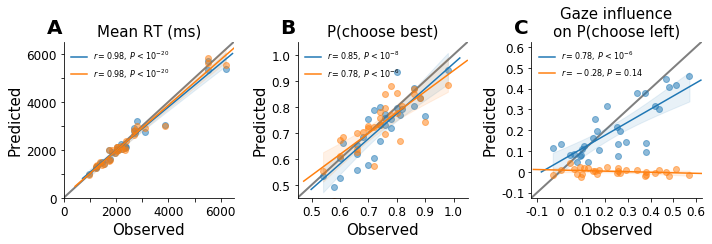

In [15]:
print('Close Figure to continue...')
figure_5(mean_rt, p_choose_best, gaze_influence)
plt.savefig('results/figures/figure_5_absolute_model_fit.png', dpi=330, bbox_inches='tight')
plt.show()